# Segmentation

Extract neuronal locations and planar time-traces.

- Apply the constrained nonnegative matrix factorization (CNMF) source separation algorithm to extract initial estimates of neuronal spatial footprints and calcium traces.
- Apply quality control metrics to evaluate the initial estimates, and narrow down to the final set of estimates.

We will use the same strategy as for motion correction. That is, to evaluate parameter sets for a single z-plane before applying those parameters to subsequent z-planes.

In [1]:
%load_ext autoreload
%autoreload 2
import os
from pathlib import Path
import logging

import mesmerize_core as mc
import warnings
from mesmerize_core.caiman_extensions.cnmf import cnmf_cache
import lbm_caiman_python as lcp

from caiman.source_extraction.cnmf import cnmf, params
from caiman.motion_correction import high_pass_filter_space
from caiman.summary_images import correlation_pnr
from caiman.utils.visualization import view_quilt
import tifffile

import matplotlib.pyplot as plt
import fastplotlib as fpl
import pandas as pd
import numpy as np
import zarr
from ipywidgets import IntSlider, VBox
from sidecar import Sidecar

try:
    import cv2
    cv2.setNumThreads(0)
except():
    pass
warnings.filterwarnings('ignore')
if os.name == "nt":
    # disable the cache on windows, this will be automatic in a future version
    cnmf_cache.set_maxsize(0)

pd.options.display.max_colwidth = 120

# Unneeded in newer versions of mesmerize-core
os.environ['CONDA_PYTHON_EXE'] = "/home/flynn/miniforge3/bin/python"
os.environ['CONDA_PREFIX_1'] = "lcp"

logger = logging.getLogger("caiman")
logger.setLevel(logging.DEBUG)
handler = logging.StreamHandler()
log_format = logging.Formatter("%(relativeCreated)12d [%(filename)s:%(funcName)10s():%(lineno)s] [%(process)d] %(message)s")
handler.setFormatter(log_format)
logger.addHandler(handler)

logging.getLogger("caiman").setLevel(logging.WARNING)

WGPU: enumerate_adapters() is deprecated, use enumerate_adapters_sync() instead.
WGPU: request_adapter() is deprecated, use request_adapter_sync() instead.


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01,\x00\x00\x007\x08\x06\x00\x00\x00\xb6\x1bw\x99\x…

## Data path setup

Data setup is similar to [motion_correction notebook](./motion_correction.ipynb).

- you can use the **same batch path** and simply add onto the end of it.
- you can define a **completely new** batch path to store these items separately.

Here, to keep data organized, we will:
1. define our previous analaysis path as `mcorr_batch_path`
2. create a new 'cnmf.pickle` to save our cnmf results.

In [2]:
# Load MCORR batch and set raw data path
parent_path = Path().home() / "caiman_data"
data_path = parent_path / 'high_res'                # where the output files from the assembly step are located
mcorr_batch_path = data_path / 'batch.pickle'  # same as motion correction

mc.set_parent_raw_data_path(str(parent_path))

mcorr_df = mc.load_batch(mcorr_batch_path)
mcorr_df

algo item_name input_movie_path  \
0  mcorr     mcorr     plane_1.tiff   

                                                                                                                    params  \
0  {'main': {'pw_rigid': True, 'max_shifts': (10, 10), 'strides': (58, 58), 'overlaps': (17, 17), 'min_mov': None, 'gSi...   

                                                                                                                   outputs  \
0  {'mean-projection-path': 906ceafb-8dc4-4d21-8938-dd31795285de\906ceafb-8dc4-4d21-8938-dd31795285de_mean_projection.n...   

            added_time             ran_time algo_duration comments  \
0  2025-01-10T10:38:21  2025-01-10T10:39:40     77.09 sec     None   

                                   uuid  
0  906ceafb-8dc4-4d21-8938-dd31795285de

In [3]:
# Now create/load a new CNMF batch
cnmf_df_path = data_path / 'cnmf_batch.pickle'
if not cnmf_df_path.exists():
    print(f'creating batch: {cnmf_df_path}')
    cnmf_df = mc.create_batch(cnmf_df_path)
else:
    cnmf_df = mc.load_batch(cnmf_df_path)

- [get_input_movie_path()](https://mesmerize-core.readthedocs.io/en/latest/api/common.html#mesmerize_core.CaimanSeriesExtensions.get_input_movie_path) allows us to easily get filepaths to our raw files

In [5]:
# we get metadata from our raw files
tiff_files = [mcorr_df.iloc[i].caiman.get_input_movie_path() for i in mcorr_df.index]
data = mcorr_df.iloc[0].caiman.get_input_movie()
metadata = lcp.get_metadata(tiff_files[0])
metadata

{'image_height': 2478,
 'image_width': 145,
 'num_pages': 51900,
 'ndim': 3,
 'dtype': 'uint16',
 'size': 18648189000,
 'shape': [51900, 2478, 145],
 'num_planes': 30,
 'num_rois': 4,
 'num_frames': 1730.0,
 'frame_rate': 9.60806,
 'fov': [150, 600],
 'pixel_resolution': [1.04, 1.0],
 'roi_width_px': 144,
 'roi_height_px': 600,
 'sample_format': 'int16',
 'num_lines_between_scanfields': 24,
 'center_xy': [-1.428571429, 0],
 'line_period': 4.15652e-05,
 'size_xy': [0.9523809524, 3.80952381],
 'objective_resolution': 157.5}

## CNMF Parameters

In this section, we'll define a `parameters` object that will subsequently be used to initialize our different estimators. 

| Parameter       | Description                                                                                                                                                                                                                                                                             | Default/Typical Value                        |
|------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------|
| `decay_time`    | Length of a typical transient in seconds. Approximation of the time scale for significant shifts in calcium signal. Defaults to `0.4` for fast indicators (e.g., GCaMP6f). Use `1` or more for slow indicators. Precise fitting is not necessary.                                       | 0.4 (fast indicators)                       |
| `p`             | Order of the autoregressive model. Use `p=0` to turn off deconvolution. Set `p=1` for instantaneous transients (e.g., low sample rate or slow indicator). Set `p=2` for visible rise time transients. Incorrect order leads to unreliable spike extraction.                              | 1 (slow), 2 (visible rise time)             |
| `nb`            | Number of global background components. Defaults to `2` for relatively homogeneous backgrounds. Use `3` for more complex noise, `1` is usually too low. Too low `nb` causes noisy traces; too high absorbs neuronal signals, reducing transients.                                       | 2                                           |
| `merge_thr`     | Merging threshold for components after initialization. Components correlated above this threshold are merged, useful for splitting neurons during initialization.                                                                                                                       | Typically between 0.7 and 0.9               |
| `rf`            | Half-size of patches in pixels. Should be at least 3–4 times larger than neuron size to capture the neuron and local background. Larger patches reduce parallelization.                                                                                                                | 3–4 × expected neuron size                  |
| `stride`        | Overlap between patches in pixels. Typically set to neuron diameter. Larger values increase computational load but improve reconstruction/denoising.                                                                                                                                | Neuron diameter (~10–20 pixels)             |
| `K`             | Expected number of components per patch. Adjust based on patch size (`rf`) and component density.                                                                                                                                                                                     | Varies based on data                        |
| `gSig`          | Expected half-size of neurons in pixels `[rows X columns]`. This is a **crucial** parameter for accurate component detection.                                                                                                                                                        | Typically matches neuron half-size          |
| `method_init`   | Initialization method. Depends on the recording method: use `greedy_roi` for 2p data, `corr_pnr` for 1p data, and `sparse_nmf` for dendritic/axonal data.                                                                                                                              | `greedy_roi`, `corr_pnr`, `sparse_nmf`      |
| `ssub/tsub`     | Spatial and temporal subsampling during initialization. Defaults to `1` (no compression). Increase (e.g., `2` or more) to save resources but at the potential cost of impaired detection/extraction quality.                                                                           | 1 (no compression), 2+ (for resource saving)|

### **The most important step**

We need to tell CaImAn our neuron size, and how many neurons to expect.

- `gSig`: Your neurons *half-size*, in `um`.

    - if your typical neuron is `14um`, `gSig` should be around 6-10.

- `K` : How many neurons should CaImAn expect, **PER PATCH**

```{warning}

`gSig_filt` controls the filter applied in `registration`. Don't confuse the two parameters!
```


In [30]:
mcorr_params = mcorr_df.params[0]
mcorr_strides = mcorr_params['main']['strides']
mcorr_overlaps = mcorr_params['main']['overlaps']
(mcorr_strides, mcorr_overlaps)

((58, 58), (17, 17))

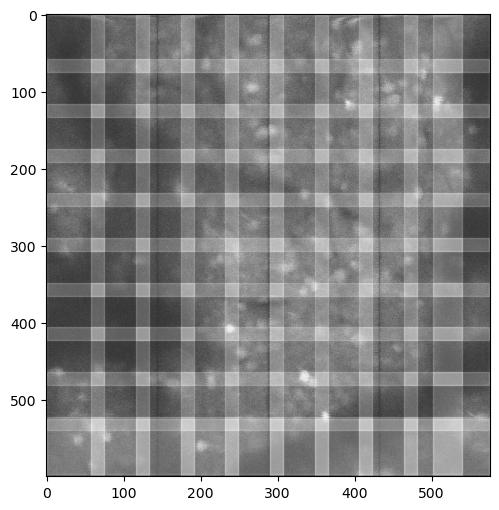

In [31]:
q = view_quilt(data[1, ...], mcorr_strides[0], mcorr_overlaps[0])

## Get values for K and gSig

`get_single_patch_coords()` takes your image dimensions and strides/overlaps values from registration to show you a single patch of your movie.

Use the last parameter, `patch_index`, to select a patch with activity. This can be a list [] or tuple (), of the row/column you want to select.

Use this widget to get an idea for the **size of your neuron** (in pixels) and the number of neurons you expect per-patch.

```{tip}
You want to *slightly* over-estimate the number of neurons for a value of `K`. 
```

In [32]:
# patch at row/col 2/3
y_start, y_end, x_start, x_end = lcp.get_single_patch_coords(data.shape[1:], mcorr_strides[0], mcorr_overlaps[0], (2, 3))
data_patch_1 = data[:, y_start:y_end, x_start:x_end] 
# patch at row/col 4/6
y_start, y_end, x_start, x_end = lcp.get_single_patch_coords(data.shape[1:], mcorr_strides[0], mcorr_overlaps[0], (4, 6))
data_patch_2 = data[:, y_start:y_end, x_start:x_end] 

RFBOutputContext()

JupyterRenderCanvas(css_height='800.0px', css_width='1600.0px')
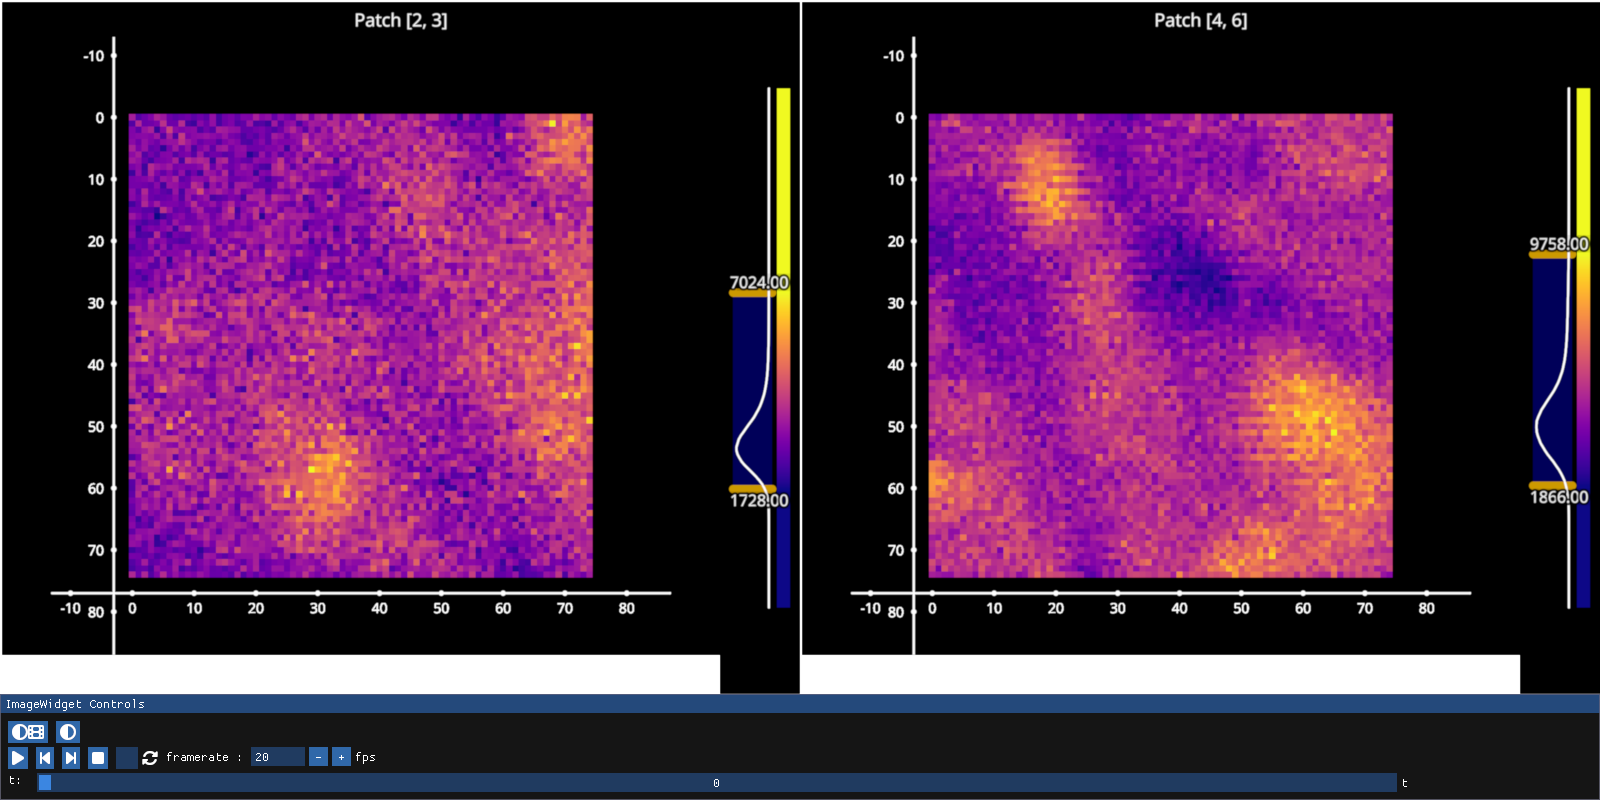

In [33]:
iw = fpl.ImageWidget(data=[data_patch_1, data_patch_2], names=["Patch [2, 3]", "Patch [4, 6]"], figure_kwargs={'size': (1600, 800)})
iw.show()

RFBOutputContext()

JupyterRenderCanvas(css_height='800.0px', css_width='1600.0px')
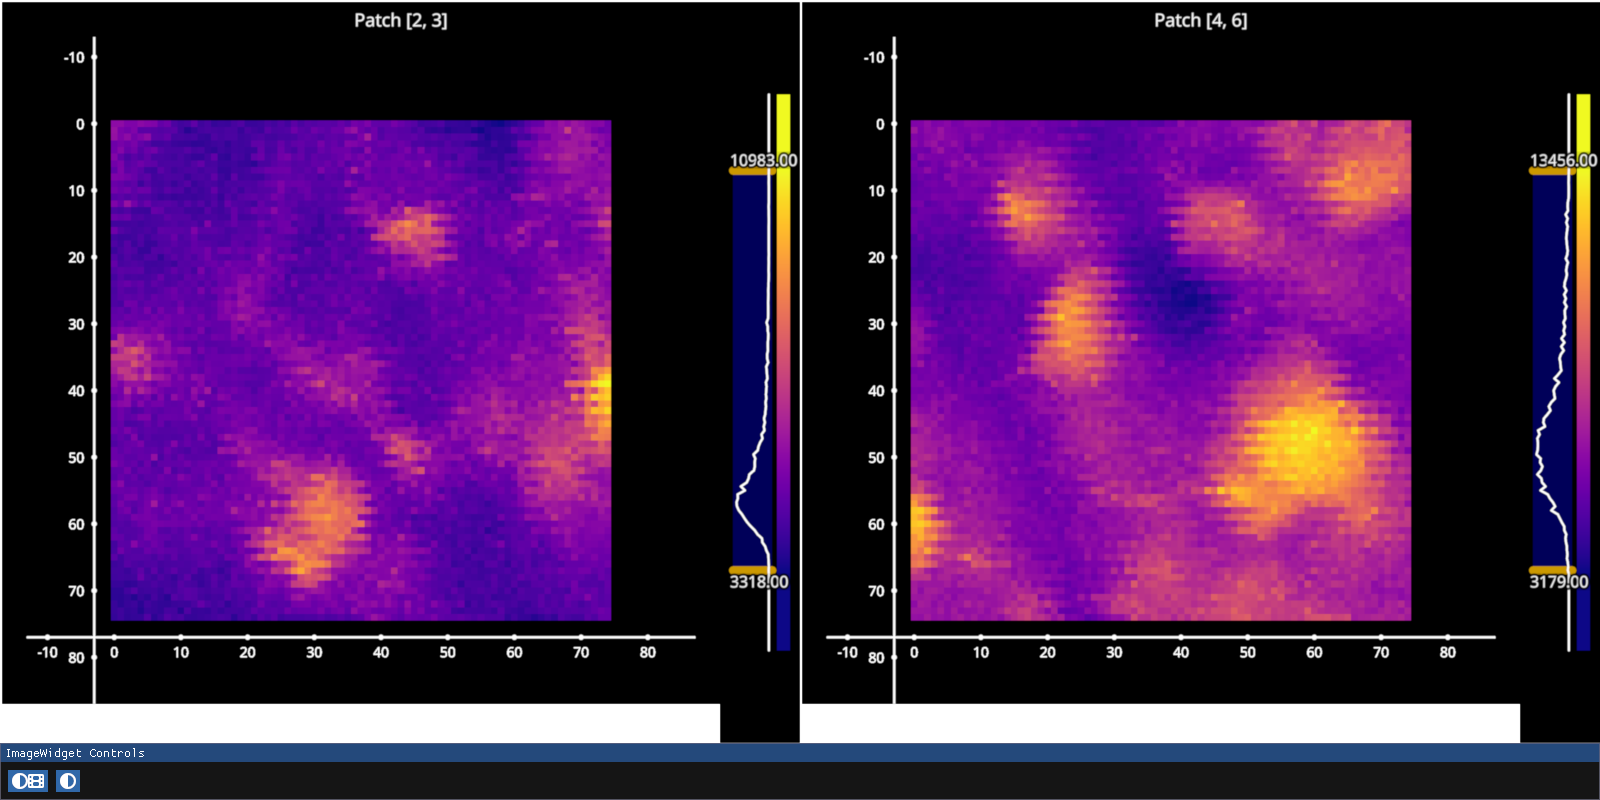

In [34]:
iw = fpl.ImageWidget(data=[data_patch_1.max(axis=0), data_patch_2.max(axis=0)], names=["Patch [2, 3]", "Patch [4, 6]"],  figure_kwargs={'size': (1600, 800)})
iw.show()

## Set new parameters

In [46]:
from copy import deepcopy

K = 12    # I counted 9/10 easily visible neurons in the above movie. Overestimating to 12 to account for neuron overlap / borders.
gSig = 7  # Set this to half the size of your neuron, so 7 um for an approximate neuron size of 12-15um.
rf = int(mcorr_strides[0])   # To mirror your motion correction size, mcorr_strides / 2 
stride = mcorr_overlaps[0]

cnmf_params = deepcopy(mcorr_params)
cnmf_params['main']['K'] = K
cnmf_params['main']['gSig'] = gSig
cnmf_params['main']['stride'] = stride

In [44]:
(rf, gSig, stride)

(29, 7, 17)

## Run the CNMF algorithm

The API is identical to running mcorr.

You can provide the mcorr item row to `input_movie_path` and it will resolve the path of the input movie from the entry in the DataFrame.

In [50]:
cnmf_df = cnmf_df.caiman.reload_from_disk()

cnmf_df.caiman.add_item(
    algo='cnmf',
    input_movie_path=mcorr_df.iloc[0], # our registration results row
    params=cnmf_params,
    item_name='cnmf-highres',
)

In [51]:
cnmf_df

algo     item_name  \
0  cnmf  cnmf-highres   

                                                                                                          input_movie_path  \
0  906ceafb-8dc4-4d21-8938-dd31795285de\906ceafb-8dc4-4d21-8938-dd31795285de-plane_1_els__d1_600_d2_576_d3_1_order_F_fr...   

                                                                                                                    params  \
0  {'main': {'pw_rigid': True, 'max_shifts': (10, 10), 'strides': (58, 58), 'overlaps': (17, 17), 'min_mov': None, 'gSi...   

  outputs           added_time ran_time algo_duration comments  \
0    None  2025-01-10T11:25:52     None          None     None   

                                   uuid  
0  58d96f5d-4723-44b6-af7d-506f15718332

```{warning}
If calling `caiman.run()` on Windows, avoid queueing / calling other jupyter cells. This can lead to the algorithm stalling.
```

In [52]:
cnmf_df.iloc[-1].caiman.run()

Running 58d96f5d-4723-44b6-af7d-506f15718332 with local backend
************************************************************************

Starting CNMF item:
algo                                                                                                                                   cnmf
item_name                                                                                                                      cnmf-highres
input_movie_path    906ceafb-8dc4-4d21-8938-dd31795285de\906ceafb-8dc4-4d21-8938-dd31795285de-plane_1_els__d1_600_d2_576_d3_1_order_F_fr...
params              {'main': {'pw_rigid': True, 'max_shifts': (10, 10), 'strides': (58, 58), 'overlaps': (17, 17), 'min_mov': None, 'gSi...
outputs                                                                                                                                None
added_time                                                                                                              2025-01-10T11:25:52
ra

     3771585 [cluster.py:setup_cluster():225] [11280] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     3771585 [cluster.py:setup_cluster():225] [11280] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     3771585 [cluster.py:setup_cluster():225] [11280] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     3771662 [params.py:change_params():1151] [11280] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
     3771662 [params.py:change_params():1151] [11280] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)

making memmap


     3782925 [cluster.py:setup_cluster():225] [11280] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     3782925 [cluster.py:setup_cluster():225] [11280] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     3782925 [cluster.py:setup_cluster():225] [11280] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


performing CNMF
fitting images
performing eval


## Checking for an errors

After a batch run, check the results to make sure the outputs do not contain a "traceback" error.

An error-free processing run will yield "None" in the cell below. Otherwise, an error will be printed.

In [ ]:
import pprint
# Only need to reload on windows, but it doesn't hurt.
cnmf_df = cnmf_df.caiman.reload_from_disk()
pprint.pprint(cnmf_df.iloc[-1].outputs["traceback"])

## Evaluate CNMF outputs

Similar to mcorr, you can use the `mesmerize-core` API to fetch the outputs.

[API reference for mesmerize-CNMF](https://mesmerize-core.readthedocs.io/en/latest/api/cnmf.html)
[API reference for caiman-CNMF](https://caiman.readthedocs.io/en/latest/Getting_Started.html#parameters)

We can get a look at the total number of traces by counting how many values are in our `estimates.C`, which holds time-traces for each neuron (both accepted and rejected).

In [54]:
cnmf_model = cnmf_df.iloc[0].cnmf.get_output()

## Plot CNMF Components

`lcp.plot_cnmf_components(df, marker_size=3)` plots the **estimates produced by CaImAn**

This is essentially a small region around each "neuron", or what CaImAn considers a neuron.

The marker is simply a dot at the center of the neuron.
Red = Accepted Neuron 
Blue = Rejected Neuronn

Marker size is set to 3
Computing centers in parallel...


Calculating neuron center coordinates: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6414/6414 [00:01<00:00, 4227.93it/s]


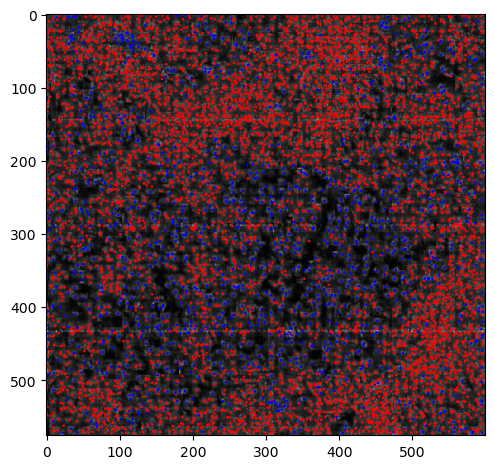

In [60]:
lcp.plot_cnmf_components(cnmf_df)

Skipping drawing centers


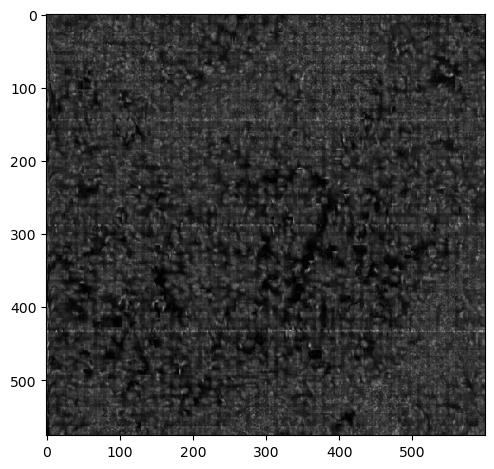

In [61]:
# set the marker_size to 0 to remove center-markers
lcp.plot_cnmf_components(cnmf_df, marker_size=0)

## View accepted neurons on a summary image

- `get_contours()` can take a while, ~3 minutes on a larger (1000x1000 4um/px) dataset.
- To view rejected neurons, simply rerun with `get_contours("bad", swap_dim=False)`

Now we're going to display a summary image to plot our segmentation results on top of. 

You can try a variety of these images to see which gives you the clearest picture of your neurons at their most active state. 

1) Correlation Image
2) Mean Image
3) Standard-deviation Image

```{code-block} python
corr = cnmf_df.iloc[-1].caiman.get_corr_image()
mean_img = cnmf_df.iloc[-1].caiman.get_projection('mean')
std_img = cnmf_df.iloc[-1].caiman.get_projection('std')
```

In [63]:
corr = cnmf_df.iloc[-1].caiman.get_corr_image()
contours = cnmf_df.iloc[-1].cnmf.get_contours("good", swap_dim=False)
filtered = [a for a in contours[0] if a.size > 1]

RFBOutputContext()

JupyterRenderCanvas(css_height='560.0px', css_width='700.0px')
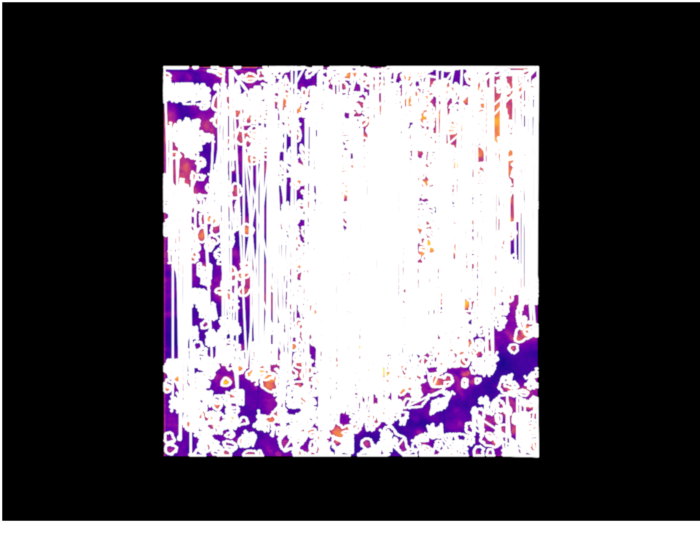

In [64]:
figure = fpl.Figure(size=(700, 560))
image_graphic = figure[0, 0].add_image(data=corr, name="Correlation Image")
subplot = figure[0, 0]
graphic = subplot.add_line_collection(
    filtered,
    name="contours"
)
figure.show()

In [ ]:
figure.close()

## What happened? 

We see many more neurons than we expect. Why is this? 

Lets check the patches used for CNMF.

Below is internally how CaImAn uses the `rf` and `stride` parameters to define patches.

Patch width: 31 , Stride: 13, Overlap: 18


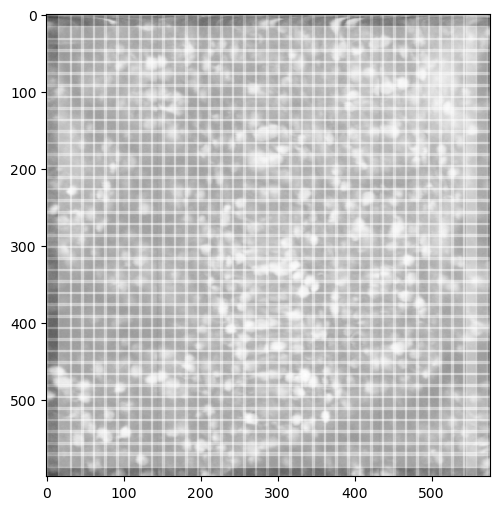

In [68]:
cnmf_patch_width = cnmf_model.params.patch['rf']*2 + 1
cnmf_patch_overlap = cnmf_model.params.patch['stride'] + 1
cnmf_patch_stride = cnmf_patch_width - cnmf_patch_overlap
print(f'Patch width: {cnmf_patch_width} , Stride: {cnmf_patch_stride}, Overlap: {cnmf_patch_overlap}');

# plot the patches
patch_ax = view_quilt(corr,  cnmf_model.params.patch['rf'],  cnmf_model.params.patch['stride']);

## Patches are tiny!

There was an error in how we set up our patches.

In [37]:
from copy import deepcopy

K = 12    # I counted 9/10 easily visible neurons in the above movie. Overestimating to 12 to account for neuron overlap / borders.
gSig = 7  # Set this to half the size of your neuron, so 7 um for an approximate neuron size of 12-15um.
rf = int(mcorr_strides[0])   # To mirror your motion correction size, mcorr_strides / 2 
stride = mcorr_overlaps[0]

cnmf_params = deepcopy(mcorr_params)
cnmf_params['main']['K'] = K
cnmf_params['main']['gSig'] = gSig
cnmf_params['main']['stride'] = stride

# this time, actually set the RF parameter!
cnmf_params['main']['rf'] = rf

## Rerun CNMF

```{note}
Setting multiple batch-items with the same `item_name` allows us to call [`df.caiman.get_params_diffs`](https://mesmerize-core.readthedocs.io/en/latest/api/common.html#mesmerize_core.CaimanDataFrameExtensions.get_params_diffs), which
gives us a nice table of parameters that differ between runs.
```

In [38]:
cnmf_df.caiman.add_item(
    algo='cnmf',
    input_movie_path=mcorr_df.iloc[0], # our registration results row
    params=cnmf_params,
    item_name='cnmf-highres',
)

In [39]:
cnmf_df.iloc[-1].caiman.run()

Running c83e5dbe-abd1-4276-a797-405230143fad with local backend
************************************************************************

Starting CNMF item:
algo                                                                                                                                   cnmf
item_name                                                                                                                      cnmf-highres
input_movie_path    906ceafb-8dc4-4d21-8938-dd31795285de\906ceafb-8dc4-4d21-8938-dd31795285de-plane_1_els__d1_600_d2_576_d3_1_order_F_fr...
params              {'main': {'pw_rigid': True, 'max_shifts': (10, 10), 'strides': (58, 58), 'overlaps': (17, 17), 'min_mov': None, 'gSi...
outputs                                                                                                                                None
added_time                                                                                                              2025-01-10T13:27:28
ra

     2693764 [cluster.py:setup_cluster():225] [15352] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     2693764 [cluster.py:setup_cluster():225] [15352] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     2693840 [params.py:change_params():1151] [15352] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
     2693840 [params.py:change_params():1151] [15352] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)


making memmap


     2704636 [cluster.py:setup_cluster():225] [15352] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     2704636 [cluster.py:setup_cluster():225] [15352] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


performing CNMF
fitting images
performing eval


In [46]:
cnmf_df = cnmf_df.caiman.reload_from_disk()
cnmf_df

algo     item_name  \
0  cnmf  cnmf-highres   
1  cnmf  cnmf-highres   

                                                                                                          input_movie_path  \
0  906ceafb-8dc4-4d21-8938-dd31795285de\906ceafb-8dc4-4d21-8938-dd31795285de-plane_1_els__d1_600_d2_576_d3_1_order_F_fr...   
1  906ceafb-8dc4-4d21-8938-dd31795285de\906ceafb-8dc4-4d21-8938-dd31795285de-plane_1_els__d1_600_d2_576_d3_1_order_F_fr...   

                                                                                                                    params  \
0  {'main': {'pw_rigid': True, 'max_shifts': (10, 10), 'strides': (58, 58), 'overlaps': (17, 17), 'min_mov': None, 'gSi...   
1  {'main': {'pw_rigid': True, 'max_shifts': (10, 10), 'strides': (58, 58), 'overlaps': (17, 17), 'min_mov': None, 'gSi...   

                                                                                                                   outputs  \
0  {'mean-projection-path': 58d96f5d-4723-44b6-af7d-506f15718332\58d96f5d-4723-44b6-af7d-506f15718332_mean_projection.n...   
1  {'mean-projection-path': c83e5dbe-abd1-4276-a797-405230143fad\c83e5dbe-abd1-4276-a797-405230143fad_mean_projection.n...   

            added_time             ran_time algo_duration comments  \
0  2025-01-10T11:25:52  2025-01-10T11:48:21   1340.78 sec     None   
1  2025-01-10T13:27:28  2025-01-10T13:28:33     64.02 sec     None   

                                   uuid  
0  58d96f5d-4723-44b6-af7d-506f15718332  
1  c83e5dbe-abd1-4276-a797-405230143fad

Marker size is set to 3
Computing centers in parallel...


Calculating neuron center coordinates: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 298/298 [00:00<00:00, 2159.43it/s]


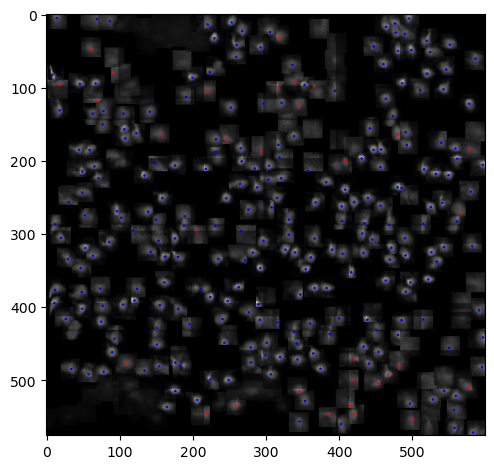

In [51]:
lcp.plot_cnmf_components(cnmf_df.iloc[-1])

RFBOutputContext()

JupyterRenderCanvas(css_height='560.0px', css_width='700.0px')
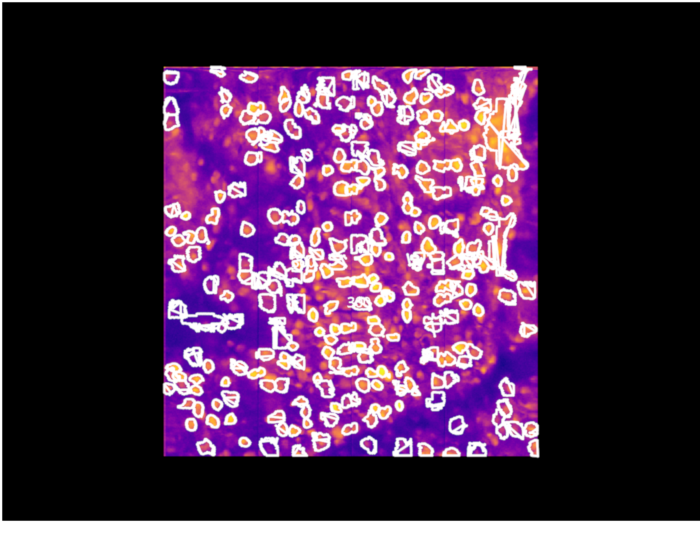

In [52]:
contours = cnmf_df.iloc[-1].cnmf.get_contours("good", swap_dim=False)
filtered = [a for a in contours[0] if a.size > 1]

figure = fpl.Figure(size=(700, 560))
image_graphic = figure[0, 0].add_image(data=corr, name="Correlation Image")
subplot = figure[0, 0]
graphic = subplot.add_line_collection(
    filtered,
    name="contours"
)
figure.show()

In [152]:
figure.close()

In [53]:
cnmf_model = cnmf_df.iloc[0].cnmf.get_output()

In [54]:
# we overestimated by ~2 neurons, now overestimte by ~10 neurons
cnmf_params['main']['K'] = 20

In [55]:
cnmf_df.caiman.add_item(
    algo='cnmf',
    input_movie_path=mcorr_df.iloc[0], # our registration results row
    params=cnmf_params,
    item_name='K_20',
)

In [4]:
cnmf_df.iloc[-1].caiman.run()

Running bfb1a6ec-b806-42d0-a7bd-1cf9d7a2363f with local backend
************************************************************************

Starting CNMF item:
algo                                                                                                                                   cnmf
item_name                                                                                                                              K_20
input_movie_path    906ceafb-8dc4-4d21-8938-dd31795285de\906ceafb-8dc4-4d21-8938-dd31795285de-plane_1_els__d1_600_d2_576_d3_1_order_F_fr...
params              {'main': {'pw_rigid': True, 'max_shifts': (10, 10), 'strides': (58, 58), 'overlaps': (17, 17), 'min_mov': None, 'gSi...
outputs                                                                                                                                None
added_time                                                                                                              2025-01-10T13:35:42
ra

       60080 [cluster.py:setup_cluster():225] [1836] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
       60153 [params.py:change_params():1151] [1836] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)


making memmap


       71317 [cluster.py:setup_cluster():225] [1836] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


performing CNMF
fitting images
performing eval


In [5]:
cnmf_df = cnmf_df.caiman.reload_from_disk()

Marker size is set to 3
Computing centers in parallel...


Calculating neuron center coordinates: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 298/298 [00:00<00:00, 2164.15it/s]


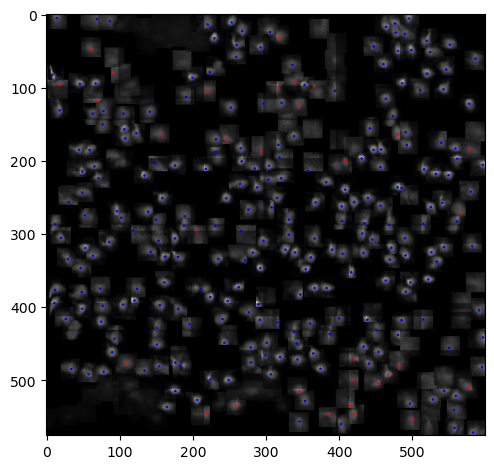

Marker size is set to 3
Computing centers in parallel...


Calculating neuron center coordinates: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 2507.08it/s]


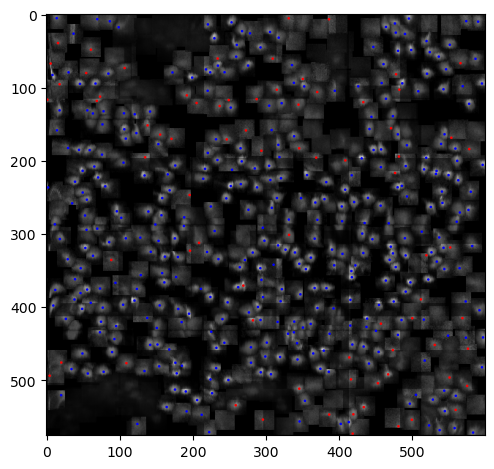

In [7]:
# you can also use a pd.Series
lcp.plot_cnmf_components(cnmf_df.iloc[-2:])

RFBOutputContext()

JupyterRenderCanvas(css_height='900.0px', css_width='900.0px')
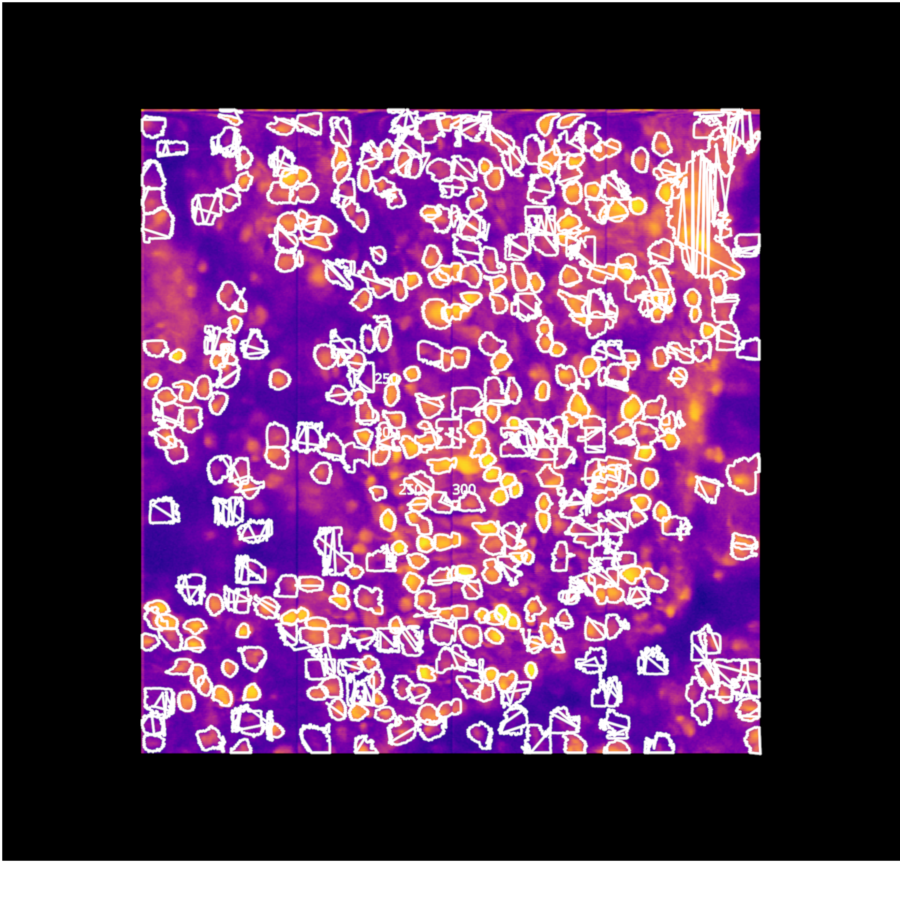

In [8]:
corr = cnmf_df.iloc[-1].caiman.get_corr_image()
contours = cnmf_df.iloc[-1].cnmf.get_contours("good", swap_dim=False)
filtered = [a for a in contours[0] if a.size > 1]

figure = fpl.Figure(size=(900, 900))
image_graphic = figure[0, 0].add_image(data=corr, name="Correlation Image")
subplot = figure[0, 0]
graphic = subplot.add_line_collection(
    filtered,
    name="contours"
)
figure.show()

## Parameter Gridsearch

Once you have a close approximation for a value of `K`, `rf`, `stride` and `gSig`, we can further tune these values with a grid-search.

```{note}
Don't include `min_SNR` or `rval_thr` in your parameter search. These can be more effectively assessed in via `mesmerize-viz`.
```

In [13]:
# itertools.product makes it easy to loop through parameter variants
# basically, it's easier to read that deeply nested for loops
from copy import deepcopy
from itertools import product

# variants of several parameters
gSig_variants = [4, 10]
K_variants = [25, 50]

# always use deepcopy like before
cnmf_params = cnmf_df.iloc[-1].params
new_params_cnmf = deepcopy(cnmf_params)

# create a parameter grid
parameter_grid = product(gSig_variants, K_variants)

# a single for loop to go through all the various parameter combinations
for gSig, K in parameter_grid:
    # deep copy params dict just like before
    new_params_cnmf = deepcopy(new_params_cnmf)

    new_params_cnmf["main"]["gSig"] = [gSig, gSig]
    new_params_cnmf["main"]["K"] = K

    # add param combination variant to batch
    cnmf_df.caiman.add_item(
        algo="cnmf",
        # TODO: This may not be a solution to choosing a name if you want a parameter variant in the name
        item_name=cnmf_df.iloc[-1]["item_name"],
        input_movie_path=cnmf_df.iloc[-1].caiman.get_input_movie_path(),
        params=new_params_cnmf
    )

## Run the `cnmf` batch items

In [6]:
for i, row in cnmf_df.iterrows():
    if row["outputs"] is not None: # item has already been run
        continue # skip

    process = row.caiman.run()

    # on Windows you MUST reload the batch dataframe after every iteration because it uses the `local` backend.
    # this is unnecessary on Linux & Mac
    # "DummyProcess" is used for local backend so this is automatic
    if process.__class__.__name__ == "DummyProcess":
        cnmf_df = cnmf_df.caiman.reload_from_disk()

Running f6299ba7-fa51-4f2c-8cf4-b27e1e18e40c with local backend
************************************************************************

Starting CNMF item:
algo                                                                                                                                   cnmf
item_name                                                                                                                              K_20
input_movie_path    906ceafb-8dc4-4d21-8938-dd31795285de\906ceafb-8dc4-4d21-8938-dd31795285de-plane_1_els__d1_600_d2_576_d3_1_order_F_fr...
params              {'main': {'pw_rigid': True, 'max_shifts': (10, 10), 'strides': (58, 58), 'overlaps': (17, 17), 'min_mov': None, 'gSi...
outputs                                                                                                                                None
added_time                                                                                                              2025-01-10T13:45:04
ra

       36167 [cluster.py:setup_cluster():225] [19564] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
       36243 [params.py:change_params():1151] [19564] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)


making memmap


       47023 [cluster.py:setup_cluster():225] [19564] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


performing CNMF
fitting images
performing eval
Running 3c73f43e-d2e1-46af-ae27-c1a5ad0f4844 with local backend
************************************************************************

Starting CNMF item:
algo                                                                                                                                   cnmf
item_name                                                                                                                              K_20
input_movie_path    906ceafb-8dc4-4d21-8938-dd31795285de\906ceafb-8dc4-4d21-8938-dd31795285de-plane_1_els__d1_600_d2_576_d3_1_order_F_fr...
params              {'main': {'pw_rigid': True, 'max_shifts': (10, 10), 'strides': (58, 58), 'overlaps': (17, 17), 'min_mov': None, 'gSi...
outputs                                                                                                                                None
added_time                                                                                     

      114278 [cluster.py:setup_cluster():225] [19564] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
      114368 [params.py:change_params():1151] [19564] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)


making memmap


      125424 [cluster.py:setup_cluster():225] [19564] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


performing CNMF
fitting images
performing eval
Running cec3b109-9d14-45de-afcb-53c86ee59388 with local backend
************************************************************************

Starting CNMF item:
algo                                                                                                                                   cnmf
item_name                                                                                                                              K_20
input_movie_path    906ceafb-8dc4-4d21-8938-dd31795285de\906ceafb-8dc4-4d21-8938-dd31795285de-plane_1_els__d1_600_d2_576_d3_1_order_F_fr...
params              {'main': {'pw_rigid': True, 'max_shifts': (10, 10), 'strides': (58, 58), 'overlaps': (17, 17), 'min_mov': None, 'gSi...
outputs                                                                                                                                None
added_time                                                                                     

      222534 [cluster.py:setup_cluster():225] [19564] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
      222611 [params.py:change_params():1151] [19564] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)


making memmap


      233880 [cluster.py:setup_cluster():225] [19564] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


performing CNMF
fitting images
performing eval
Running ff3303d7-e579-4786-9990-ca9c01fc5052 with local backend
************************************************************************

Starting CNMF item:
algo                                                                                                                                   cnmf
item_name                                                                                                                              K_20
input_movie_path    906ceafb-8dc4-4d21-8938-dd31795285de\906ceafb-8dc4-4d21-8938-dd31795285de-plane_1_els__d1_600_d2_576_d3_1_order_F_fr...
params              {'main': {'pw_rigid': True, 'max_shifts': (10, 10), 'strides': (58, 58), 'overlaps': (17, 17), 'min_mov': None, 'gSi...
outputs                                                                                                                                None
added_time                                                                                     

      302682 [cluster.py:setup_cluster():225] [19564] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
      302749 [params.py:change_params():1151] [19564] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)


making memmap


      313760 [cluster.py:setup_cluster():225] [19564] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


performing CNMF
fitting images
performing eval


In [8]:
cnmf_df = cnmf_df.caiman.reload_from_disk()
cnmf_df

algo     item_name  \
0  cnmf  cnmf-highres   
1  cnmf  cnmf-highres   
2  cnmf          K_20   
3  cnmf          K_20   
4  cnmf          K_20   
5  cnmf          K_20   
6  cnmf          K_20   

                                                                                                          input_movie_path  \
0  906ceafb-8dc4-4d21-8938-dd31795285de\906ceafb-8dc4-4d21-8938-dd31795285de-plane_1_els__d1_600_d2_576_d3_1_order_F_fr...   
1  906ceafb-8dc4-4d21-8938-dd31795285de\906ceafb-8dc4-4d21-8938-dd31795285de-plane_1_els__d1_600_d2_576_d3_1_order_F_fr...   
2  906ceafb-8dc4-4d21-8938-dd31795285de\906ceafb-8dc4-4d21-8938-dd31795285de-plane_1_els__d1_600_d2_576_d3_1_order_F_fr...   
3  906ceafb-8dc4-4d21-8938-dd31795285de\906ceafb-8dc4-4d21-8938-dd31795285de-plane_1_els__d1_600_d2_576_d3_1_order_F_fr...   
4  906ceafb-8dc4-4d21-8938-dd31795285de\906ceafb-8dc4-4d21-8938-dd31795285de-plane_1_els__d1_600_d2_576_d3_1_order_F_fr...   
5  906ceafb-8dc4-4d21-8938-dd31795285de\906ceafb-8dc4-4d21-8938-dd31795285de-plane_1_els__d1_600_d2_576_d3_1_order_F_fr...   
6  906ceafb-8dc4-4d21-8938-dd31795285de\906ceafb-8dc4-4d21-8938-dd31795285de-plane_1_els__d1_600_d2_576_d3_1_order_F_fr...   

                                                                                                                    params  \
0  {'main': {'pw_rigid': True, 'max_shifts': (10, 10), 'strides': (58, 58), 'overlaps': (17, 17), 'min_mov': None, 'gSi...   
1  {'main': {'pw_rigid': True, 'max_shifts': (10, 10), 'strides': (58, 58), 'overlaps': (17, 17), 'min_mov': None, 'gSi...   
2  {'main': {'pw_rigid': True, 'max_shifts': (10, 10), 'strides': (58, 58), 'overlaps': (17, 17), 'min_mov': None, 'gSi...   
3  {'main': {'pw_rigid': True, 'max_shifts': (10, 10), 'strides': (58, 58), 'overlaps': (17, 17), 'min_mov': None, 'gSi...   
4  {'main': {'pw_rigid': True, 'max_shifts': (10, 10), 'strides': (58, 58), 'overlaps': (17, 17), 'min_mov': None, 'gSi...   
5  {'main': {'pw_rigid': True, 'max_shifts': (10, 10), 'strides': (58, 58), 'overlaps': (17, 17), 'min_mov': None, 'gSi...   
6  {'main': {'pw_rigid': True, 'max_shifts': (10, 10), 'strides': (58, 58), 'overlaps': (17, 17), 'min_mov': None, 'gSi...   

                                                                                                                   outputs  \
0  {'mean-projection-path': 58d96f5d-4723-44b6-af7d-506f15718332\58d96f5d-4723-44b6-af7d-506f15718332_mean_projection.n...   
1  {'mean-projection-path': c83e5dbe-abd1-4276-a797-405230143fad\c83e5dbe-abd1-4276-a797-405230143fad_mean_projection.n...   
2  {'mean-projection-path': bfb1a6ec-b806-42d0-a7bd-1cf9d7a2363f\bfb1a6ec-b806-42d0-a7bd-1cf9d7a2363f_mean_projection.n...   
3  {'mean-projection-path': f6299ba7-fa51-4f2c-8cf4-b27e1e18e40c\f6299ba7-fa51-4f2c-8cf4-b27e1e18e40c_mean_projection.n...   
4  {'mean-projection-path': 3c73f43e-d2e1-46af-ae27-c1a5ad0f4844\3c73f43e-d2e1-46af-ae27-c1a5ad0f4844_mean_projection.n...   
5  {'mean-projection-path': cec3b109-9d14-45de-afcb-53c86ee59388\cec3b109-9d14-45de-afcb-53c86ee59388_mean_projection.n...   
6  {'mean-projection-path': ff3303d7-e579-4786-9990-ca9c01fc5052\ff3303d7-e579-4786-9990-ca9c01fc5052_mean_projection.n...   

            added_time             ran_time algo_duration comments  \
0  2025-01-10T11:25:52  2025-01-10T11:48:21   1340.78 sec     None   
1  2025-01-10T13:27:28  2025-01-10T13:28:33     64.02 sec     None   
2  2025-01-10T13:35:42  2025-01-10T13:38:48      72.8 sec     None   
3  2025-01-10T13:45:04  2025-01-10T13:47:26     78.11 sec     None   
4  2025-01-10T13:45:04  2025-01-10T13:49:14    108.25 sec     None   
5  2025-01-10T13:45:04  2025-01-10T13:50:34     80.14 sec     None   
6  2025-01-10T13:45:04  2025-01-10T13:52:28    113.17 sec     None   

                                   uuid  
0  58d96f5d-4723-44b6-af7d-506f15718332  
1  c83e5dbe-abd1-4276-a797-405230143fad  
2  bfb1a6ec-b806-42d0-a7bd-1cf9d7a2363f  
3  f6299ba7-fa51-4f2c-8cf4-b27e1e18e40c  
4  3

Marker size is set to 3
Computing centers in parallel...


Calculating neuron center coordinates: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 661.83it/s]


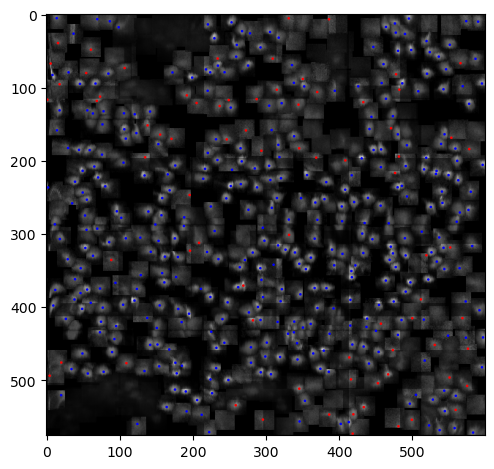

Marker size is set to 3
Computing centers in parallel...


Calculating neuron center coordinates: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 567/567 [00:00<00:00, 3056.25it/s]


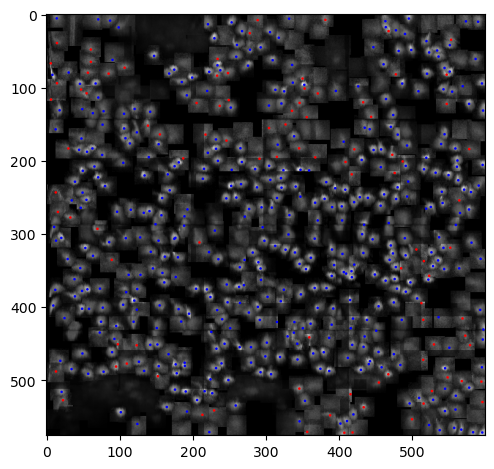

Marker size is set to 3
Computing centers in parallel...


Calculating neuron center coordinates: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1077/1077 [00:00<00:00, 3893.05it/s]


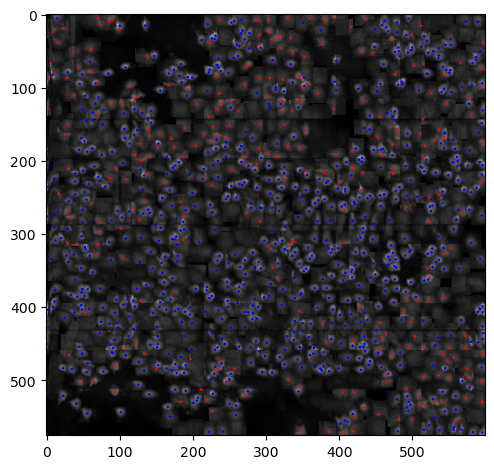

Marker size is set to 3
Computing centers in parallel...


Calculating neuron center coordinates: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 584/584 [00:00<00:00, 3020.64it/s]


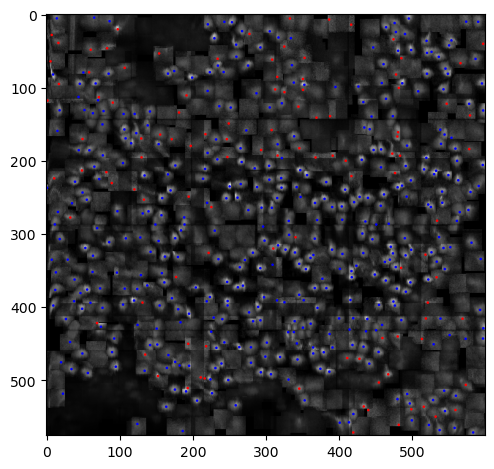

Marker size is set to 3
Computing centers in parallel...


Calculating neuron center coordinates: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1097/1097 [00:00<00:00, 4187.82it/s]


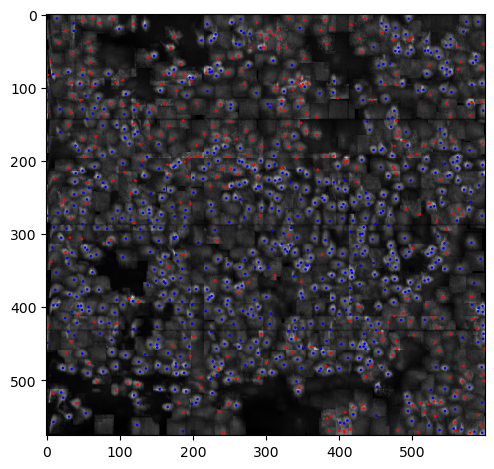

In [9]:
lcp.plot_cnmf_components(cnmf_df.iloc[2:])

RFBOutputContext()

JupyterRenderCanvas(css_height='900.0px', css_width='900.0px')
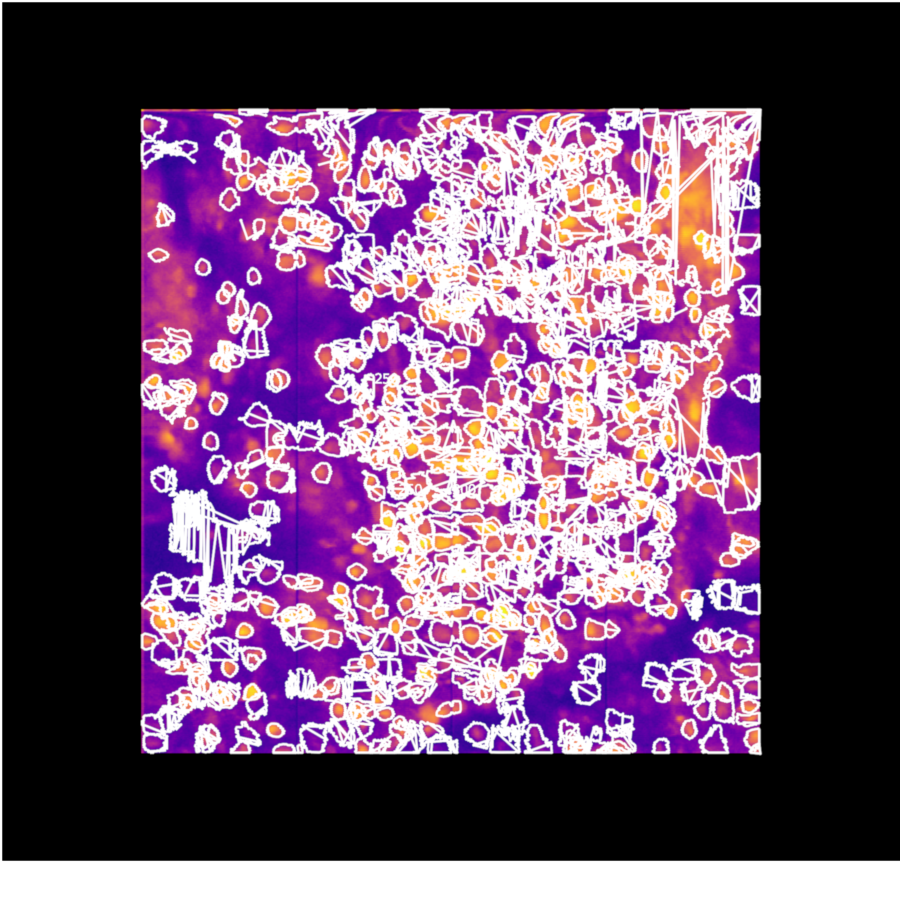

Error during handling key_up event
Traceback (most recent call last):
  File "C:\Users\RBO\miniforge3\envs\lcp\lib\site-packages\rendercanvas\_coreutils.py", line 41, in log_exception
    yield
  File "C:\Users\RBO\miniforge3\envs\lcp\lib\site-packages\rendercanvas\_events.py", line 222, in emit
    callback(event)
  File "C:\Users\RBO\miniforge3\envs\lcp\lib\site-packages\wgpu\utils\imgui\imgui_renderer.py", line 190, in _on_key
    key = ord(key_name.lower())
TypeError: ord() expected a character, but string of length 12 found


In [13]:
corr = cnmf_df.iloc[-4].caiman.get_corr_image()
contours = cnmf_df.iloc[-1].cnmf.get_contours("good", swap_dim=False)
filtered = [a for a in contours[0] if a.size > 1]

figure = fpl.Figure(size=(900, 900))
image_graphic = figure[0, 0].add_image(data=corr, name="Correlation Image")
subplot = figure[0, 0]
graphic = subplot.add_line_collection(
    filtered,
    name="contours"
)
figure.show()

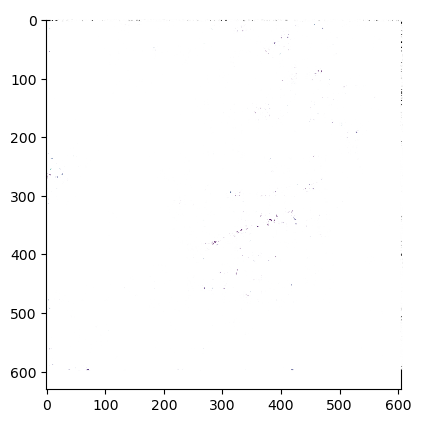

In [28]:
cnmf_model = cnmf_df.iloc[0].cnmf.get_output()
cnmf_model.estimates.plot_contours()

In [216]:
image_data_options = [ "input", ]
viz = cnmf_df.cnmf.viz(start_index=0, image_data_options=image_data_options)
viz.show()

RFBOutputContext()

RFBOutputContext()

RFBOutputContext()

In [217]:
viz.close()

## Pick the best parameter set

In [221]:
rows_keep = [0]
for i, row in cnmf_df.iterrows():
    if i not in rows_keep:
        cnmf_df.caiman.remove_item(row.uuid, safe_removal=False)
cnmf_df

algo item_name  \
0  cnmf  k_5_cnmf   

                                                                                                          input_movie_path  \
0  d2323217-2056-4681-9656-2ddebc721ac4\d2323217-2056-4681-9656-2ddebc721ac4-plane_10_els__d1_600_d2_576_d3_1_order_F_f...   

                                                                                                                    params  \
0  {'main': {'fr': 9.60806, 'use_cnn': False, 'dxy': (1.04, 1.0), 'method_init': 'greedy_roi', 'K': 10, 'gSig': (4, 4),...   

                                                                                                                   outputs  \
0  {'mean-projection-path': a5561c84-a784-433d-9e92-44112397245f\a5561c84-a784-433d-9e92-44112397245f_mean_projection.n...   

            added_time             ran_time algo_duration comments  \
0  2024-12-07T17:11:24  2024-12-07T17:15:25    108.93 sec     None   

                                   uuid  
0  a5561c84-a784-433d-9e92-44112397245f

## Adjust quality metrics based on evaluation parameters

``` python
min_SNR: float
    trace SNR threshold
SNR_lowest: float
    minimum required trace SNR
rval_thr: float
    space correlation threshold
rval_lowest: float
    minimum required space correlation
use_cnn: bool
    flag for using the CNN classifier
min_cnn_thr: float
    CNN classifier threshold
```

In [218]:
from copy import deepcopy

new_params = deepcopy(cnmf_df.iloc[0].params)

# assign the "max_shifts"
new_params["main"]["min_SNR"] = 2.1
new_params["main"]["SNR_lowest"] = 3.25
new_params["main"]["rval_thr"] = 0.3
# new_params["main"]["rval_lowest"] = 0.0

In [219]:
cnmf_df = cnmf_df.caiman.reload_from_disk()
cnmf_df

algo item_name  \
0  cnmf  k_5_cnmf   

                                                                                                          input_movie_path  \
0  d2323217-2056-4681-9656-2ddebc721ac4\d2323217-2056-4681-9656-2ddebc721ac4-plane_10_els__d1_600_d2_576_d3_1_order_F_f...   

                                                                                                                    params  \
0  {'main': {'fr': 9.60806, 'use_cnn': False, 'dxy': (1.04, 1.0), 'method_init': 'greedy_roi', 'K': 10, 'gSig': (4, 4),...   

                                                                                                                   outputs  \
0  {'mean-projection-path': a5561c84-a784-433d-9e92-44112397245f\a5561c84-a784-433d-9e92-44112397245f_mean_projection.n...   

            added_time             ran_time algo_duration comments  \
0  2024-12-07T17:11:24  2024-12-07T17:15:25    108.93 sec     None   

                                   uuid  
0  a5561c84-a784-433d-9e92-44112397245f

In [222]:
output_path = Path(cnmf_df.iloc[0].input_movie_path).stem
for i, row in mcorr_df.iterrows():
    # Don't process the same file twice
    if Path(row.mcorr.get_output_path()).stem == output_path:
        continue

    cnmf_df.caiman.add_item(
        algo='cnmf',
        input_movie_path=row,
        params=new_params,          # use the same parameters
        item_name=f'cnmf_batch',  # filename of the movie, but can be anything
    )

In [225]:
# double check that the new value is set properly
cnmf_df.iloc[-1].params['main']['min_SNR']

2.1

In [ ]:
for i, row in cnmf_df.iterrows():
    if row["outputs"] is not None: # item has already been run
        continue # skip

    process = row.caiman.run()

    # on Windows you MUST reload the batch dataframe after every iteration because it uses the `local` backend.
    # this is unnecessary on Linux & Mac
    # "DummyProcess" is used for local backend so this is automatic
    if process.__class__.__name__ == "DummyProcess":
        cnmf_df = cnmf_df.caiman.reload_from_disk()

## Extras

In [ ]:
import fastplitlib as fpl

# create image widget for raw neural activity
raw_iw = fpl.Figure()

# re-add our identified good components from before using the SNR mapping
contours_graphic = raw_iw[0,0].add_line_collection(data=contours, cmap="spring", thickness=2, name="contours")

# get temporal components
temporal = df.iloc[row_ix].cnmf.get_temporal(component_indices="good")

# temporal plot
plot_temporal = fpl.Figure(size=(600,100))
plot_temporal[0,0].add_line(temporal[0], colors="magenta")

# add a linear selector to temporal trace
plot_temporal[0,0].graphics[0].add_linear_selector()

# show temporal plot and mcorr/rcm plot in ipywidgets VBox
sc = Sidecar()

# with sc:
display(VBox([raw_iw.show(), plot_temporal.show()]))

In [24]:
index = -1  # the last item added

rcb = df.iloc[index].cnmf.get_rcb()
residuals = df.iloc[index].cnmf.get_residuals()
input_movie = df.iloc[index].caiman.get_input_movie()

# temporal components
temporal = df.iloc[index].cnmf.get_temporal()

temporal_good = df.iloc[index].cnmf.get_temporal("good")
temporal_bad = df.iloc[index].cnmf.get_temporal("bad")

temporal_with_residuals = df.iloc[index].cnmf.get_temporal(add_residuals=True)

correlation_image = df.iloc[-1].caiman.get_corr_image()

components_good = df.iloc[-1].cnmf.get_good_components()
components_bad = df.iloc[-1].cnmf.get_bad_components()

mean_img = df.iloc[-1].caiman.get_projection('mean')
std_img = df.iloc[-1].caiman.get_projection('std')

masks = df.iloc[-1].cnmf.get_masks()

print(f'Temporal Components (good/bad): {temporal_good.shape} / {temporal_bad.shape}')
print(f'Spatial Components (good/bad): {components_good.shape} / {components_bad.shape}')

Temporal Components (good/bad): (2111, 1000) / (2683, 1000)
Spatial Components (good/bad): (2111,) / (2683,)


In [ ]:
row_ix = 1
# get the contours and center of masses using mesmerize_core
contours, coms = df.iloc[row_ix].cnmf.get_contours(component_indices="good", swap_dim=False)

# get the signal-to-noise ratio of each "good" component to color components
snr_comps = df.iloc[row_ix].cnmf.get_output().estimates.SNR_comp

# get the good component_ixs
good_ixs = df.iloc[row_ix].cnmf.get_good_components()

# only get snr_comps of good_ixs
snr_comps = snr_comps[good_ixs]

np.log10(snr_comps)[:10]